# 1. Lendo os dados e filtrando eles

In [2]:
import pandas as pd

path = 'data/processed/df_avisos_completos.csv'
df = pd.read_csv(path)

print(df.shape)
df.head()

(50259, 4)


,id_aviso,data_hora,teor_texto,setor_destino
0,18612632.0,2024-06-21 05:00:40,PODER JUDICIÁRIO ESTADO DO RIO GRANDE DO NORTE...,Procuradoria da Saúde
1,18629258.0,2024-06-25 23:59:59,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Procuradoria Administrativa
2,18629422.0,2024-06-18 09:27:16,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Cartorio
3,18629665.0,2024-07-30 23:59:59,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Apoio Fiscal
4,18629671.0,2024-06-18 05:01:05,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Procuradoria Fiscal


In [3]:
df['setor_destino'].value_counts()

setor_destino
Procuradoria Administrativa                    16106
Apoio Fiscal                                   14396
Procuradoria Fiscal                             6720
Procuradoria Judicial                           3475
Departamento de Cálculos e Contabilidade        3323
Procuradoria da Saúde                           1849
Chefia Administrativa                           1574
Chefia Judicial                                 1242
Requisitório de Pagamento - Contabilidade        660
Chefia Meio Ambiente                             346
Chefia Patrimonial                               258
Enviar Carta                                     114
Procuradoria Geral                                48
Assessoria - Gabinete                             44
Procuradoria Patrimonial                          40
Procuradoria do Meio Ambiente                     34
Cartorio                                          11
Chefia Fiscal                                      8
Procuradoria de Recuperação da D

# 2. Separação de Treinamento/Teste

## 2.1 - Filtragem no dataset
Para a criação do classificador será considerado as seguintes classes seguindo o documento criado por Iara (Cartório):

In [4]:
classes = [
    'Procuradoria Judicial',
    'Chefia Judicial',
    'Procuradoria Administrativa',
    'Chefia Administrativa',
    'Procuradoria Fiscal',
    'Apoio Fiscal',
    'Procuradoria do Meio Ambiente',
    'Chefia Meio Ambiente',
    'Procuradoria Patrimonial',
    'Chefia Patrimonial',
    'Procuradoria da Saúde',
    'Departamento de Cálculos e Contabilidade',
    'Requisitório de Pagamento - Contabilidade'
]

df_filtrado = df[df['setor_destino'].isin(classes)].copy()

print(f'Essa filtragem corresponde a cerca de {len(df_filtrado)/len(df)*100:.2f}% do dataset original')

Essa filtragem corresponde a cerca de 99.53% do dataset original


Juntando classes como:

* Chefia Adminsitrativa + Procuradoria Administrativa
* Chefia Judicial + Procuradoria Judicial
* Chefia Meio Ambiente + Procuradoria do Meio Ambiente
* Chefia Patrimonial + Procuradoria Patrimonial
* Departamento de Cálculos e Contabilidade + Requisitório de Pagamentos - Contabilidade

In [5]:
swap_dict = {
    'Chefia Administrativa': 'Procuradoria Administrativa',
    'Chefia Judicial': 'Procuradoria Judicial',
    'Chefia Meio Ambiente': 'Procuradoria do Meio Ambiente',
    'Chefia Patrimonial': 'Procuradoria Patrimonial',
    'Requisitório de Pagamento - Contabilidade': 'Departamento de Cálculos e Contabilidade'
}

# Substituindo valores acima
df_filtrado.replace(swap_dict, inplace=True)

df_filtrado['setor_destino'].value_counts()

setor_destino
Procuradoria Administrativa                 17680
Apoio Fiscal                                14396
Procuradoria Fiscal                          6720
Procuradoria Judicial                        4717
Departamento de Cálculos e Contabilidade     3983
Procuradoria da Saúde                        1849
Procuradoria do Meio Ambiente                 380
Procuradoria Patrimonial                      298
Name: count, dtype: int64

## 2.2 - Separação de Treino/Teste

In [6]:
from sklearn.model_selection import train_test_split

y = df_filtrado['setor_destino']
X = df_filtrado['teor_texto']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

In [7]:
y_train.value_counts(normalize=True)

setor_destino
Procuradoria Administrativa                 0.353441
Apoio Fiscal                                0.287795
Procuradoria Fiscal                         0.134340
Procuradoria Judicial                       0.094308
Departamento de Cálculos e Contabilidade    0.079614
Procuradoria da Saúde                       0.036958
Procuradoria do Meio Ambiente               0.007597
Procuradoria Patrimonial                    0.005947
Name: proportion, dtype: float64

# 3. Pré-processamento

A etapa de pré-processamento serve para a remoção de cabeçalhos e rodapés dos textos, antes de passar pelo classificador os textos deverão passar por essa função antes.

In [8]:
import re

def limpar_cabecalho_rodape(texto: str) -> str:
    """
    Remove cabeçalho (palavras-chave do topo) e rodapé (Natal/RN com variações)
    do 'texto' e retorna o resultado em minúsculas.
    - A detecção do cabeçalho é *sensível a maiúsculas/minúsculas* (como no seu código).
    - A detecção do rodapé é *case-insensitive* e tolera espaços entre letras.
    """

    if not isinstance(texto, str):
        return texto
    
    # Palavras-chave do cabeçalho
    palavras_cabecalho = [
        'ATO ORDINATÓRIO', 'DESPACHO', 'CERTIDÃO', 'DECISÃO', 'SENTENÇA', 'INTIMAÇÃO'
    ]

    # Constrói um padrão "folgado" que aceita espaços entre TODAS as letras
    # Ex.: "ATO ORDINATÓRIO" -> A\s*T\s*O\s*O\s*R\s*D...

    def padrao_flex(termo: str) -> str:
        s = ''.join(termo.split())
        return r'(?<!\w)' + r'\s*'.join(map(re.escape, s)) + r'(?!\w)'
    
    # Cabeçalho: Alternância de todos os termos
    re_cabecalho = re.compile('|'.join(padrao_flex(t) for t in palavras_cabecalho))
    m = re_cabecalho.search(texto)

    if m:
        texto = texto[m.end():] # corta tudo até o fim do match do cabeçalho

    # Rodapé: "Natal/RN" com ou sem espaços e case-insensitive
    re_rodape = re.compile(r'N\s*A\s*T\s*A\s*L\s*/\s*R\s*N', flags=re.IGNORECASE)
    r = re_rodape.search(texto)
    if r:
        texto = texto[:r.start()] # corta a partir do inicio do rodapé

    return texto.strip().lower()

In [9]:
X_train_clean = X_train.apply(limpar_cabecalho_rodape)
X_test_clean = X_test.apply(limpar_cabecalho_rodape)

# 4. Verificando duplicatas em X_train_clean

In [10]:
print(f'Temos {X_train_clean.duplicated().sum()} textos duplicados nos dados de treinamento após o pré-processamento\nAssim se distribuem as duplicatas:')

# Contagem absoluta
abs_counts = y_train.value_counts()

# Contagem duplicatas
dub_counts = y_train[X_train_clean.duplicated()].value_counts()

df_contagem = pd.DataFrame({
    'contagem_absoluta': abs_counts,
    'contagem_duplicata': dub_counts
}).fillna(0).astype(int)

# Calcula percentual em relação ao y_train original
df_contagem["percentual"] = (df_contagem["contagem_absoluta"] / len(y_train) * 100).round(2)

# Reseta o índice para virar coluna
df_contagem = df_contagem.reset_index().rename(columns={"index": "setor_destino"})
df_contagem.sort_values('contagem_absoluta', ascending=False)

Temos 11728 textos duplicados nos dados de treinamento após o pré-processamento
Assim se distribuem as duplicatas:


,setor_destino,contagem_absoluta,contagem_duplicata,percentual
2,Procuradoria Administrativa,14144,3625,35.34
0,Apoio Fiscal,11517,5882,28.78
3,Procuradoria Fiscal,5376,705,13.43
4,Procuradoria Judicial,3774,1086,9.43
1,Departamento de Cálculos e Contabilidade,3186,211,7.96
6,Procuradoria da Saúde,1479,169,3.70
7,Procuradoria do Meio Ambiente,304,23,0.76
5,Procuradoria Patrimonial,238,27,0.59


In [11]:
X_train_clean_filtered = X_train_clean.drop_duplicates()
y_train_filtered = y_train[X_train_clean_filtered.index]

print(f'Distribuição final das classes após remoção de duplicatas')
y_train_filtered.value_counts()

Distribuição final das classes após remoção de duplicatas


setor_destino
Procuradoria Administrativa                 10519
Apoio Fiscal                                 5635
Procuradoria Fiscal                          4671
Departamento de Cálculos e Contabilidade     2975
Procuradoria Judicial                        2688
Procuradoria da Saúde                        1310
Procuradoria do Meio Ambiente                 281
Procuradoria Patrimonial                      211
Name: count, dtype: int64

In [12]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(
    sampling_strategy={
        'Procuradoria Administrativa':1000,
        'Apoio Fiscal':1000,
        'Procuradoria Fiscal':1000,
        'Departamento de Cálculos e Contabilidade':1000,
        'Procuradoria Judicial':1000,
        'Procuradoria da Saúde':1000
    },
    random_state=42
)

ros = RandomOverSampler(
    sampling_strategy={
        'Procuradoria do Meio Ambiente': 1000,
        'Procuradoria Patrimonial': 1000
    }
)

X_resampled, y_resampled = rus.fit_resample(X_train_clean_filtered.values.reshape(-1, 1), y_train_filtered.values)
X_resampled, y_resampled = ros.fit_resample(X_resampled.reshape(-1, 1), y_resampled)

# 5. Pipelines de classificação

In [181]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

skf = StratifiedKFold(n_splits=4, shuffle=True)

## 5.1 - TFIDF + Logistic Regression

In [182]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform, uniform

lr_pipeline = Pipeline(steps=[
    ('feature_extraction', TfidfVectorizer()),
    ('classificador', LogisticRegression())
])

params_search = {
    'feature_extraction__max_features': [128, 256, 512, 1024, 2048],
    'feature_extraction__ngram_range': [(1,1), (1,2), (1,3)],

    'classificador__C': loguniform(1e-4, 1e3),
    'classificador__penalty': ['l1', 'l2'],
    'classificador__solver': ['liblinear', 'saga'],
    'classificador__max_iter': [100, 200, 500],
    'classificador__class_weight': ['balanced', None],
    'classificador__tol': uniform(1e-5, 1e-3)
}

random_search_lr = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=params_search,
    n_iter=30,
    cv=skf,
    scoring='f1_weighted',
    verbose=5,
    n_jobs=-1
)

#random_search_lr.fit(X_train_clean_filtered, y_train_filtered)
random_search_lr.fit(pd.Series(X_resampled[:, 0], name='teor_texto'), y_resampled)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[CV 2/4] END classificador__C=0.005116170210869137, classificador__class_weight=None, classificador__max_iter=500, classificador__penalty=l1, classificador__solver=liblinear, classificador__tol=4.719025519211683e-05, feature_extraction__max_features=128, feature_extraction__ngram_range=(1, 2);, score=0.028 total time=  11.7s
[CV 1/4] END classificador__C=0.005116170210869137, classificador__class_weight=None, classificador__max_iter=500, classificador__penalty=l1, classificador__solver=liblinear, classificador__tol=4.719025519211683e-05, feature_extraction__max_features=128, feature_extraction__ngram_range=(1, 2);, score=0.028 total time=  12.1s
[CV 4/4] END classificador__C=0.005116170210869137, classificador__class_weight=None, classificador__max_iter=500, classificador__penalty=l1, classificador__solver=liblinear, classificador__tol=4.719025519211683e-05, feature_extraction__max_features=128, feature_extraction__ngram_ran

/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/4] END classificador__C=0.0020693316127077554, classificador__class_weight=balanced, classificador__max_iter=500, classificador__penalty=l2, classificador__solver=liblinear, classificador__tol=0.0005255013705179471, feature_extraction__max_features=512, feature_extraction__ngram_range=(1, 2);, score=0.513 total time=  11.9s


/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/4] END classificador__C=48.38899539106563, classificador__class_weight=None, classificador__max_iter=200, classificador__penalty=l1, classificador__solver=saga, classificador__tol=0.000699663130679586, feature_extraction__max_features=256, feature_extraction__ngram_range=(1, 3);, score=0.744 total time=  45.2s
[CV 2/4] END classificador__C=48.38899539106563, classificador__class_weight=None, classificador__max_iter=200, classificador__penalty=l1, classificador__solver=saga, classificador__tol=0.000699663130679586, feature_extraction__max_features=256, feature_extraction__ngram_range=(1, 3);, score=0.748 total time=  45.3s
[CV 1/4] END classificador__C=48.38899539106563, classificador__class_weight=None, classificador__max_iter=200, classificador__penalty=l1, classificador__solver=saga, classificador__tol=0.000699663130679586, feature_extraction__max_features=256, feature_extraction__ngram_range=(1, 3);, score=0.747 total time=  45.8s
[CV 4/4] END classificador__C=48.3889953910656

/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/4] END classificador__C=0.8720889213674022, classificador__class_weight=balanced, classificador__max_iter=500, classificador__penalty=l1, classificador__solver=liblinear, classificador__tol=0.00017401676246484477, feature_extraction__max_features=2048, feature_extraction__ngram_range=(1, 3);, score=0.750 total time=  27.4s
[CV 1/4] END classificador__C=0.8720889213674022, classificador__class_weight=balanced, classificador__max_iter=500, classificador__penalty=l1, classificador__solver=liblinear, classificador__tol=0.00017401676246484477, feature_extraction__max_features=2048, feature_extraction__ngram_range=(1, 3);, score=0.773 total time=  28.4s
[CV 2/4] END classificador__C=0.8720889213674022, classificador__class_weight=balanced, classificador__max_iter=500, classificador__penalty=l1, classificador__solver=liblinear, classificador__tol=0.00017401676246484477, feature_extraction__max_features=2048, feature_extraction__ngram_range=(1, 3);, score=0.768 total time=  28.3s
[CV 4/4

/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/4] END classificador__C=362.2759582797398, classificador__class_weight=None, classificador__max_iter=100, classificador__penalty=l2, classificador__solver=saga, classificador__tol=0.0006334439124849219, feature_extraction__max_features=2048, feature_extraction__ngram_range=(1, 3);, score=0.837 total time=  32.1s
[CV 1/4] END classificador__C=362.2759582797398, classificador__class_weight=None, classificador__max_iter=100, classificador__penalty=l2, classificador__solver=saga, classificador__tol=0.0006334439124849219, feature_extraction__max_features=2048, feature_extraction__ngram_range=(1, 3);, score=0.829 total time=  33.6s
[CV 1/4] END classificador__C=0.0025826490234808334, classificador__class_weight=balanced, classificador__max_iter=100, classificador__penalty=l2, classificador__solver=liblinear, classificador__tol=9.597259377408961e-05, feature_extraction__max_features=128, feature_extraction__ngram_range=(1, 1);, score=0.473 total time=   4.0s
[CV 3/4] END classificador__

/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('feature_extraction',
                                              TfidfVectorizer()),
                                             ('classificador',
                                              LogisticRegression())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'classificador__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x713641f07ef0>,
                                        'classificador__class_...
                                        'classificador__max_iter': [100, 200,
                                                                    500],
                                        'classificador__penalty': ['l1', 'l2'],
                                        'classificador__solver': ['liblinear',
                                                                  'saga'],
                                        'classificador__tol': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x713647a1f800>,
                                        'feature_extraction__max_features': [128,
                                                                             256,
                                                                             512,
                                                                             1024,
                                                                             2048],
                                        'feature_extraction__ngram_range': [(1,
                                                                             1),
                                                                            (1,
                                                                             2),
                                                                            (1,
                                                                             3)]},
                   scoring='f1_weighted', verbose=5)

In [183]:
pd.DataFrame(random_search_lr.cv_results_).sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classificador__C,param_classificador__class_weight,param_classificador__max_iter,param_classificador__penalty,param_classificador__solver,param_classificador__tol,param_feature_extraction__max_features,param_feature_extraction__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
19,30.082724,0.601013,3.158471,0.132740,362.275958,None,100,l2,saga,0.000633,2048,"(1, 3)","{'classificador__C': 362.2759582797398, 'class...",0.829332,0.837347,0.838433,0.848997,0.838527,0.006992,1
10,10.367612,0.480441,1.037652,0.113108,113.594249,balanced,100,l1,liblinear,0.000925,2048,"(1, 1)","{'classificador__C': 113.59424892431831, 'clas...",0.825987,0.838657,0.828506,0.846389,0.834885,0.008161,2
21,24.811164,0.358401,3.175356,0.072864,0.872089,balanced,500,l1,liblinear,0.000174,2048,"(1, 3)","{'classificador__C': 0.8720889213674022, 'clas...",0.773369,0.767944,0.749809,0.771640,0.765690,0.009376,3
0,42.755170,0.313343,2.823642,0.125871,48.388995,None,200,l1,saga,0.000700,256,"(1, 3)","{'classificador__C': 48.38899539106563, 'class...",0.747174,0.748203,0.743647,0.752122,0.747786,0.003020,4
15,18.481666,1.062875,1.948064,0.104456,73.352274,None,500,l2,saga,0.000097,256,"(1, 2)","{'classificador__C': 73.35227354320583, 'class...",0.753827,0.753994,0.731559,0.751559,0.747735,0.009388,5


In [184]:
y_pred = random_search_lr.best_estimator_.predict(X_test_clean)

                                          precision    recall  f1-score   support

                            Apoio Fiscal     0.9412    0.9278    0.9344      2879
Departamento de Cálculos e Contabilidade     0.9652    0.9749    0.9700       797
             Procuradoria Administrativa     0.9144    0.6646    0.7697      3536
                     Procuradoria Fiscal     0.7456    0.7240    0.7346      1344
                   Procuradoria Judicial     0.4701    0.7084    0.5651       943
                Procuradoria Patrimonial     0.1534    0.4833    0.2329        60
                   Procuradoria da Saúde     0.5754    0.8351    0.6814       370
           Procuradoria do Meio Ambiente     0.1000    0.4474    0.1635        76

                                accuracy                         0.7807     10005
                               macro avg     0.6082    0.7207    0.6315     10005
                            weighted avg     0.8383    0.7807    0.7980     10005



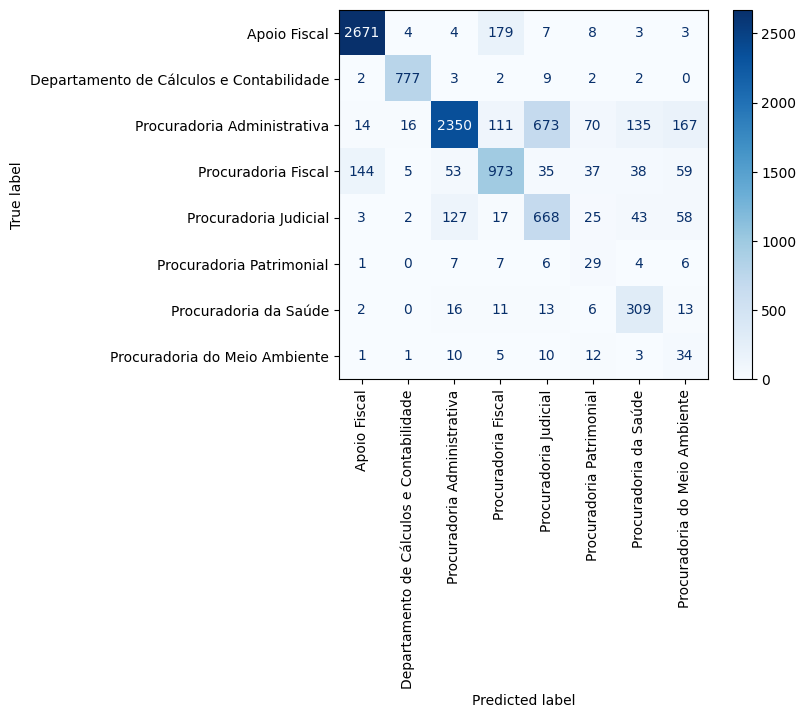

In [185]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

print(classification_report(y_true=y_test, y_pred=y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap=plt.cm.Blues,
    xticks_rotation=90
)

plt.show()

## 5.2 - TFIDF + Random Forest

In [187]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import loguniform, uniform, randint

rf_pipeline = Pipeline(steps=[
    ('feature_extraction', TfidfVectorizer()),
    ('classificador', RandomForestClassifier())
])

params_search = {
    'feature_extraction__max_features': [128, 256, 512, 1024, 2048],
    'feature_extraction__ngram_range': [(1,1), (1,2), (1,3)],

    'classificador__n_estimators': randint(50, 300),
    'classificador__max_depth': list(range(10, 101, 10)),
    'classificador__min_samples_split': uniform(0.01, 0.1),
    'classificador__min_samples_leaf': uniform(0.001, 0.05),
    'classificador__max_features': ['sqrt', 'log2', None],
    'classificador__class_weight': ['balanced', 'balanced_subsample', None],
    'classificador__criterion': ['gini', 'entropy', 'log_loss']
}

random_search_rf = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=params_search,
    n_iter=30,
    cv=skf,
    scoring='f1_weighted',
    verbose=3,
    n_jobs=-1
)

#random_search_rf.fit(X_train_clean_filtered, y_train_filtered)
random_search_rf.fit(pd.Series(X_resampled[:, 0], name='teor_texto'), y_resampled)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


[CV 4/4] END classificador__class_weight=balanced, classificador__criterion=entropy, classificador__max_depth=80, classificador__max_features=log2, classificador__min_samples_leaf=0.0035748880256560194, classificador__min_samples_split=0.0507082857836323, classificador__n_estimators=89, feature_extraction__max_features=512, feature_extraction__ngram_range=(1, 3);, score=0.639 total time=  21.1s
[CV 3/4] END classificador__class_weight=balanced, classificador__criterion=entropy, classificador__max_depth=80, classificador__max_features=log2, classificador__min_samples_leaf=0.0035748880256560194, classificador__min_samples_split=0.0507082857836323, classificador__n_estimators=89, feature_extraction__max_features=512, feature_extraction__ngram_range=(1, 3);, score=0.648 total time=  21.4s
[CV 1/4] END classificador__class_weight=balanced, classificador__criterion=entropy, classificador__max_depth=80, classificador__max_features=log2, classificador__min_samples_leaf=0.0035748880256560194, c

RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('feature_extraction',
                                              TfidfVectorizer()),
                                             ('classificador',
                                              RandomForestClassifier())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'classificador__class_weight': ['balanced',
                                                                        'balanced_subsample',
                                                                        None],
                                        'classificador__criterion': ['gini',
                                                                     'entropy',
                                                                     'l...
                                        'classificador__min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x713641e7db50>,
                                        'classificador__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x713636d36240>,
                                        'feature_extraction__max_features': [128,
                                                                             256,
                                                                             512,
                                                                             1024,
                                                                             2048],
                                        'feature_extraction__ngram_range': [(1,
                                                                             1),
                                                                            (1,
                                                                             2),
                                                                            (1,
                                                                             3)]},
                   scoring='f1_weighted', verbose=3)

In [188]:
pd.DataFrame(random_search_rf.cv_results_).sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classificador__class_weight,param_classificador__criterion,param_classificador__max_depth,param_classificador__max_features,param_classificador__min_samples_leaf,param_classificador__min_samples_split,...,param_feature_extraction__max_features,param_feature_extraction__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
3,6.047787,0.240480,0.988097,0.078083,balanced_subsample,gini,30,sqrt,0.007918,0.106419,...,1024,"(1, 1)",{'classificador__class_weight': 'balanced_subs...,0.687702,0.672214,0.689971,0.684552,0.683610,0.006855,1
2,19.253645,0.419575,2.454578,0.035560,balanced,entropy,80,log2,0.003575,0.050708,...,512,"(1, 3)","{'classificador__class_weight': 'balanced', 'c...",0.636228,0.640574,0.648328,0.639199,0.641082,0.004469,2
28,21.962798,0.535302,1.864884,0.305798,balanced,gini,50,sqrt,0.015828,0.043986,...,512,"(1, 3)","{'classificador__class_weight': 'balanced', 'c...",0.631029,0.637960,0.628447,0.635831,0.633317,0.003769,3
22,22.028550,0.403632,2.934266,0.179328,balanced_subsample,gini,80,sqrt,0.023372,0.076786,...,2048,"(1, 3)",{'classificador__class_weight': 'balanced_subs...,0.628741,0.636477,0.642789,0.617715,0.631431,0.009352,4
14,270.892904,4.247365,1.833105,0.179313,None,entropy,30,None,0.003048,0.058741,...,512,"(1, 2)","{'classificador__class_weight': None, 'classif...",0.642537,0.607554,0.606244,0.641402,0.624434,0.017546,5


In [189]:
y_pred = random_search_rf.best_estimator_.predict(X_test_clean)

                                          precision    recall  f1-score   support

                            Apoio Fiscal     0.7839    0.9059    0.8405      2879
Departamento de Cálculos e Contabilidade     0.9611    0.9611    0.9611       797
             Procuradoria Administrativa     0.8853    0.6485    0.7486      3536
                     Procuradoria Fiscal     0.7013    0.4368    0.5383      1344
                   Procuradoria Judicial     0.5373    0.5270    0.5321       943
                Procuradoria Patrimonial     0.0468    0.6167    0.0871        60
                   Procuradoria da Saúde     0.7753    0.7459    0.7603       370
           Procuradoria do Meio Ambiente     0.0836    0.4211    0.1394        76

                                accuracy                         0.7092     10005
                               macro avg     0.5968    0.6579    0.5759     10005
                            weighted avg     0.7895    0.7092    0.7352     10005



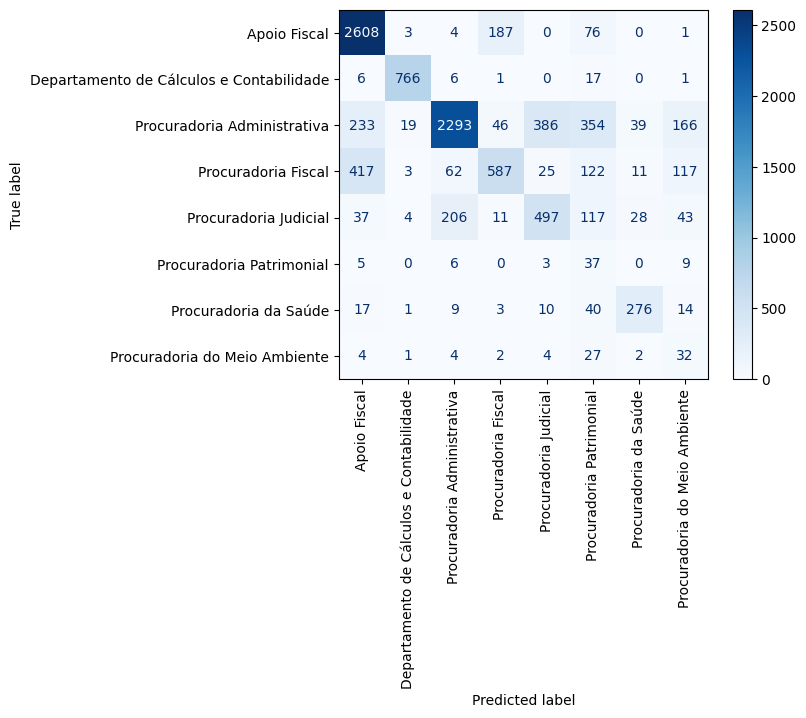

In [190]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

print(classification_report(y_true=y_test, y_pred=y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap=plt.cm.Blues,
    xticks_rotation=90
)

plt.show()

## 5.3 - TFIDF + SVM

In [192]:
from sklearn.svm import SVC
from scipy.stats import loguniform, uniform, randint

svm_pipeline = Pipeline(steps=[
    ('feature_extraction', TfidfVectorizer()),
    ('classificador', SVC())
])

params_search = {
    'feature_extraction__max_features': [128, 256, 512, 1024, 2048],
    'feature_extraction__ngram_range': [(1,1), (1,2), (1,3)],

    'classificador__C': loguniform(1e-3, 1e3),
    'classificador__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'classificador__gamma': loguniform(1e-4, 1e1),
    'classificador__degree': randint(2, 6),
    'classificador__class_weight': ['balanced', None],
    'classificador__tol': loguniform(1e-5, 1e-2)
}

random_search_svm = RandomizedSearchCV(
    estimator=svm_pipeline,
    param_distributions=params_search,
    n_iter=30,
    cv=skf,
    scoring='f1_weighted',
    verbose=3,
    n_jobs=-1
)

#random_search_svm.fit(X_train_clean_filtered, y_train_filtered)
random_search_svm.fit(pd.Series(X_resampled[:, 0], name='teor_texto'), y_resampled)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


[CV 3/4] END classificador__C=227.5881596818309, classificador__class_weight=None, classificador__degree=4, classificador__gamma=0.00014281693593180068, classificador__kernel=rbf, classificador__tol=0.009174125125342186, feature_extraction__max_features=256, feature_extraction__ngram_range=(1, 3);, score=0.634 total time= 1.3min
[CV 4/4] END classificador__C=227.5881596818309, classificador__class_weight=None, classificador__degree=4, classificador__gamma=0.00014281693593180068, classificador__kernel=rbf, classificador__tol=0.009174125125342186, feature_extraction__max_features=256, feature_extraction__ngram_range=(1, 3);, score=0.643 total time= 1.3min
[CV 1/4] END classificador__C=227.5881596818309, classificador__class_weight=None, classificador__degree=4, classificador__gamma=0.00014281693593180068, classificador__kernel=rbf, classificador__tol=0.009174125125342186, feature_extraction__max_features=256, feature_extraction__ngram_range=(1, 3);, score=0.640 total time= 1.3min
[CV 2/4

RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('feature_extraction',
                                              TfidfVectorizer()),
                                             ('classificador', SVC())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'classificador__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x713641d553d0>,
                                        'classificador__class_weight': ['balan...
                                        'classificador__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x713641d57ec0>,
                                        'classificador__kernel': ['linear',
                                                                  'rbf', 'poly',
                                                                  'sigmoid'],
                                        'classificador__tol': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x713641d56540>,
                                        'feature_extraction__max_features': [128,
                                                                             256,
                                                                             512,
                                                                             1024,
                                                                             2048],
                                        'feature_extraction__ngram_range': [(1,
                                                                             1),
                                                                            (1,
                                                                             2),
                                                                            (1,
                                                                             3)]},
                   scoring='f1_weighted', verbose=3)

In [193]:
pd.DataFrame(random_search_svm.cv_results_).sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classificador__C,param_classificador__class_weight,param_classificador__degree,param_classificador__gamma,param_classificador__kernel,param_classificador__tol,param_feature_extraction__max_features,param_feature_extraction__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
17,23.094527,0.311258,9.490197,0.215726,40.558804,balanced,5,0.007717,linear,0.005094,1024,"(1, 1)","{'classificador__C': 40.55880401239592, 'class...",0.822890,0.825130,0.831693,0.813797,0.823377,0.006408,1
5,19.685396,1.268530,6.369122,0.183197,6.304049,balanced,5,3.081371,rbf,0.008445,128,"(1, 1)","{'classificador__C': 6.304048660648234, 'class...",0.818328,0.815050,0.815223,0.801813,0.812603,0.006365,2
25,20.931123,1.352038,8.285487,0.512321,12.964724,None,3,0.019128,linear,0.000045,512,"(1, 1)","{'classificador__C': 12.96472395743853, 'class...",0.812004,0.800145,0.813918,0.800216,0.806571,0.006426,3
3,61.300567,0.645619,11.643475,0.430910,0.814120,None,5,2.759330,poly,0.000256,1024,"(1, 1)","{'classificador__C': 0.8141195564426723, 'clas...",0.807632,0.805117,0.807283,0.803417,0.805862,0.001709,4
27,49.008005,2.183669,15.653003,0.705685,44.862509,None,5,0.007274,sigmoid,0.000443,2048,"(1, 1)","{'classificador__C': 44.862508639689054, 'clas...",0.766661,0.758811,0.780893,0.757013,0.765845,0.009416,5


In [194]:
y_pred = random_search_svm.best_estimator_.predict(X_test_clean)

                                          precision    recall  f1-score   support

                            Apoio Fiscal     0.9214    0.9288    0.9251      2879
Departamento de Cálculos e Contabilidade     0.9652    0.9749    0.9700       797
             Procuradoria Administrativa     0.8983    0.6646    0.7640      3536
                     Procuradoria Fiscal     0.7189    0.6830    0.7005      1344
                   Procuradoria Judicial     0.4524    0.7211    0.5560       943
                Procuradoria Patrimonial     0.1791    0.4000    0.2474        60
                   Procuradoria da Saúde     0.6525    0.8270    0.7294       370
           Procuradoria do Meio Ambiente     0.1171    0.4605    0.1867        76

                                accuracy                         0.7760     10005
                               macro avg     0.6131    0.7075    0.6349     10005
                            weighted avg     0.8248    0.7760    0.7899     10005



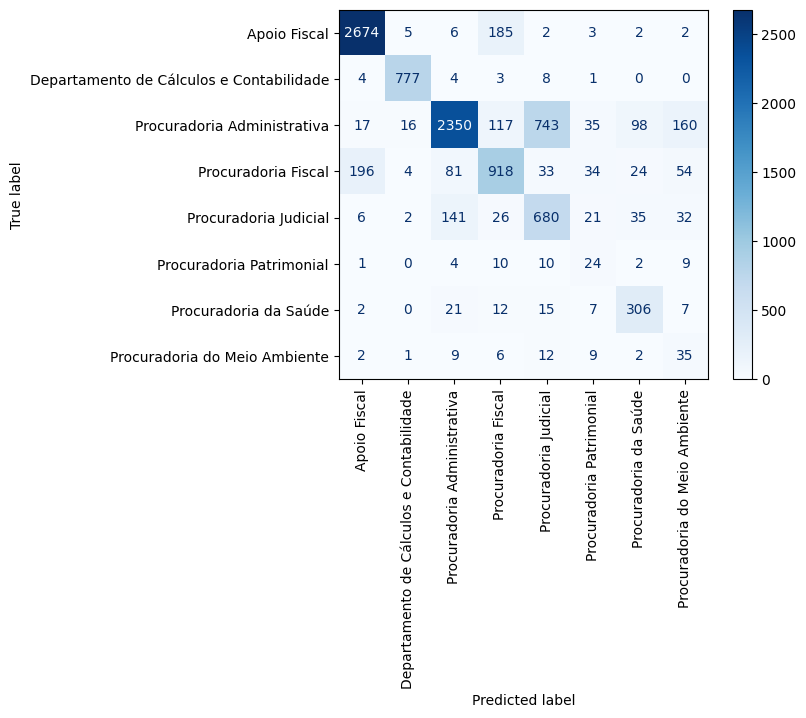

In [195]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

print(classification_report(y_true=y_test, y_pred=y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap=plt.cm.Blues,
    xticks_rotation=90
)

plt.show()

# 6. Utilizando melhor classificador testado

O melhor resultado obtido pode ser considerado o uso do TFIDF + Regressão Logísitica com os seguintes parâmetros testados:

* **TFIDF**
    * max_features = 2048
    * ngram_range = (1, 2)

* **Regressão Logísitica**
    * tol = 0.000095
    * solver = liblinear
    * penalty = l2
    * max_iter = 200
    * class_weight = balanced
    * C = 6.893930

	

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

lr_pipeline = Pipeline(steps=[
    ('feature_extraction', TfidfVectorizer(
        max_features=2048, 
        ngram_range=(1, 2)
    )),
    ('classificador', LogisticRegression(
        C=6.89393,
        penalty='l2',
        solver='liblinear',
        max_iter=200,
        class_weight='balanced',
        tol=0.000095,
        n_jobs=-1
    ))
])

import mlflow
import mlflow.sklearn

# Aponta para o /mlruns do repositório mlruns
TRACKING_URI = 'file:///home/esdras-daniel/Documentos/GitHub/pgm-ia/api_service/mlruns'
mlflow.set_tracking_uri(TRACKING_URI)

experiment = mlflow.set_experiment(experiment_name='clf_setor_destino')

with mlflow.start_run(run_name=f'TFIDF + Linear Regression', experiment_id=experiment.experiment_id):
    
    # Treinando o modelo
    print('Treinando o modelo...')
    lr_pipeline.fit(X_train_clean_filtered, y_train_filtered)

    # Avaliando o modelo
    print('Avaliando o modelo...')
    #y_pred_train = lr_pipeline.predict(X_train_clean_filtered)
    #y_proba_train = lr_pipeline.predict_proba(X_train_clean_filtered)

    y_pred_test = lr_pipeline.predict(X_test_clean)
    y_proba_test = lr_pipeline.predict_proba(X_test_clean)

    auc_macro = roc_auc_score(y_test, y_proba_test, multi_class='ovr', average='macro')
    auc_weighted = roc_auc_score(y_test, y_proba_test, multi_class='ovr', average='weighted')

    acc = accuracy_score(y_test, y_pred_test)

    precision_macro = precision_score(y_test, y_pred_test, average='macro')
    precision_weighted = precision_score(y_test, y_pred_test, average='weighted')

    recall_macro = recall_score(y_test, y_pred_test, average='macro')
    recall_weighted = recall_score(y_test, y_pred_test, average='weighted')
    
    f1_score_macro = f1_score(y_test, y_pred_test, average='macro')
    f1_score_weighted = f1_score(y_test, y_pred_test, average='weighted')

    # Logando os parâmetros do classificador
    mlflow.log_params(lr_pipeline.get_params())

    # Logando as métricas obtidas
    mlflow.log_metrics(
        {
            'acuracia': acc,
            'auc_macro': auc_macro,
            'auc_weighted': auc_weighted,
            'precision_macro': precision_macro,
            'precision_weighted': precision_weighted,
            'recall_macro': recall_macro,
            'recall_weighted': recall_weighted,
            'f1_score_macro': f1_score_macro,
            'f1_score_weighted': f1_score_weighted,
        }
    )

    # Modelo Final
    mlflow.sklearn.log_model(lr_pipeline)


Treinando o modelo...


/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


Avaliando o modelo...


2025/09/16 14:34:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## 6.1 - Avaliando melhor o modelo

                                          precision    recall  f1-score   support

                            Apoio Fiscal    0.94448   0.96318   0.95374      2879
Departamento de Cálculos e Contabilidade    0.97132   0.97742   0.97436       797
             Procuradoria Administrativa    0.88190   0.83626   0.85847      3536
                     Procuradoria Fiscal    0.79451   0.79688   0.79569      1344
                   Procuradoria Judicial    0.60504   0.61082   0.60792       943
                Procuradoria Patrimonial    0.30097   0.51667   0.38037        60
                   Procuradoria da Saúde    0.81769   0.82432   0.82100       370
           Procuradoria do Meio Ambiente    0.24638   0.44737   0.31776        76

                                accuracy                        0.85217     10005
                               macro avg    0.69529   0.74661   0.71366     10005
                            weighted avg    0.85851   0.85217   0.85471     10005



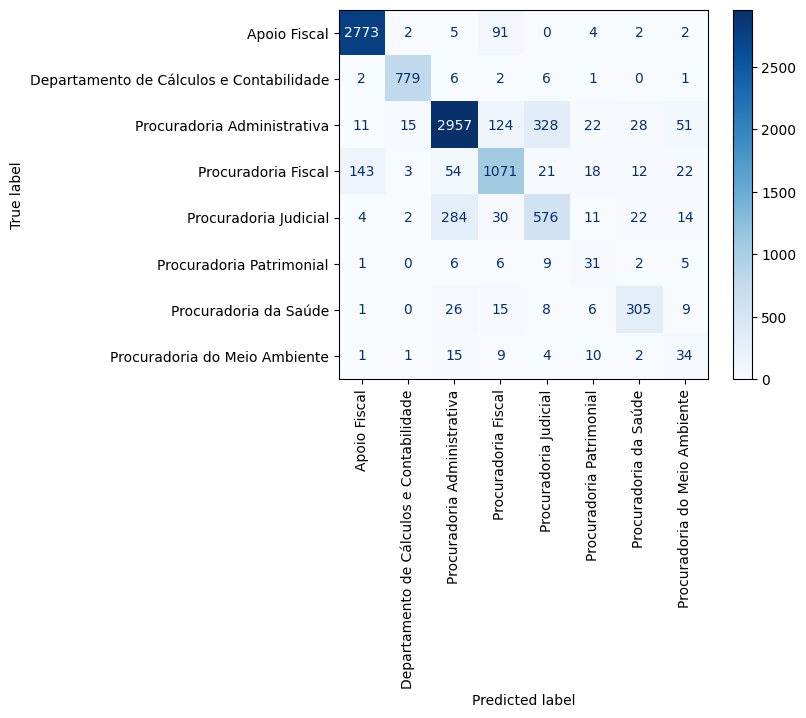

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

print(classification_report(y_true=y_test, y_pred=y_pred_test, digits=5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_test,
    cmap=plt.cm.Blues,
    xticks_rotation=90
)

plt.show()

In [33]:
# AUC, Curva ROC e Curva Precisão-Recall por classe

roc_auc_curves = []

for i, classe in enumerate(lr_pipeline.classes_):
    auc = roc_auc_score(
        y_true=(y_test == classe).astype(int),
        y_score=y_proba_test[:, i]
    )
    roc = roc_curve(
        y_true=(y_test == classe).astype(int),
        y_score=y_proba_test[:, i]
    )
    pr_curve = precision_recall_curve(
        y_true=(y_test == classe).astype(int),
        y_score=y_proba_test[:, i]
    )

    roc_auc_curves.append((classe, auc, roc, pr_curve))

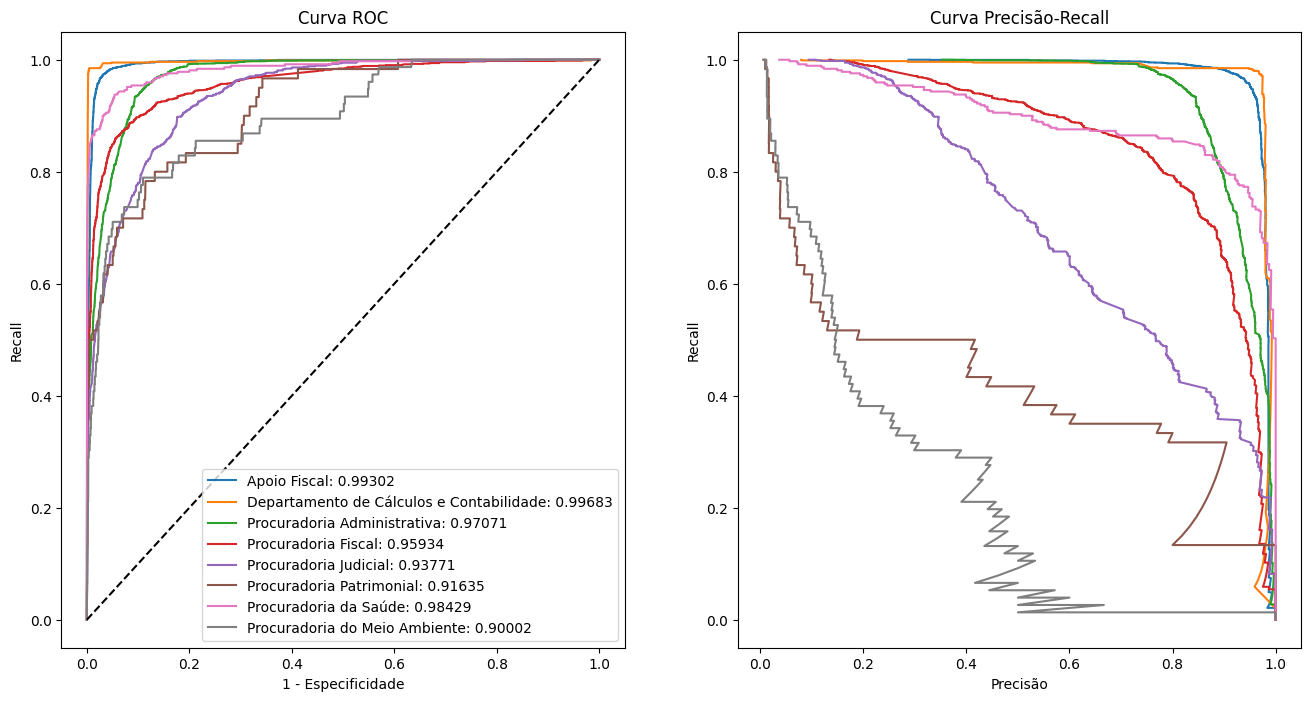

In [34]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

for label, auc_score, roc_curve, pr_curve in roc_auc_curves:
    ax1.plot(roc_curve[0], roc_curve[1], label=f'{label}: {auc_score:.5f}')
    ax2.plot(pr_curve[0], pr_curve[1], label=f'{label}')
ax1.plot([0, 1], [0, 1], color='black', linestyle='dashed')

ax1.set_title("Curva ROC")
ax1.set_xlabel("1 - Especificidade")
ax1.set_ylabel("Recall")

ax2.set_title("Curva Precisão-Recall")
ax2.set_xlabel("Precisão")
ax2.set_ylabel("Recall")

ax1.legend()
plt.show()

In [ ]:
import numpy as np

def return_report_dfs(model, X, y_true):
    """Retorna N DataFrames com informações de classificação"""

    y_proba = model.predict_proba(X)

    reports = []

    for i, classe in enumerate(model.classes_):
        
        report = (y_true == classe).astype(int).to_frame(name = classe).reset_index(drop=True)
        report['PRED'] = y_proba[:, i]
        report.sort_values(by='PRED', ascending=False, inplace=True)
        report['ACUM_CLASS'] = report[classe].cumsum()
        report['PCT_ACUM_CLASS'] = report['ACUM_CLASS'] / report[classe].sum()
        report['QTDE_OBS'] = pd.Series(1, index=report.index).cumsum()
        report['PCT_OBS'] = report['QTDE_OBS'] / report.shape[0]
        report['MEAN_CLASS'] = report['ACUM_CLASS'] / report['QTDE_OBS']
        report['LIFT_CLASS'] = report['MEAN_CLASS'] / report[classe].mean()

        reports.append(report)
    
    return reports

reports = return_report_dfs(lr_pipeline, X_test_clean, y_test)


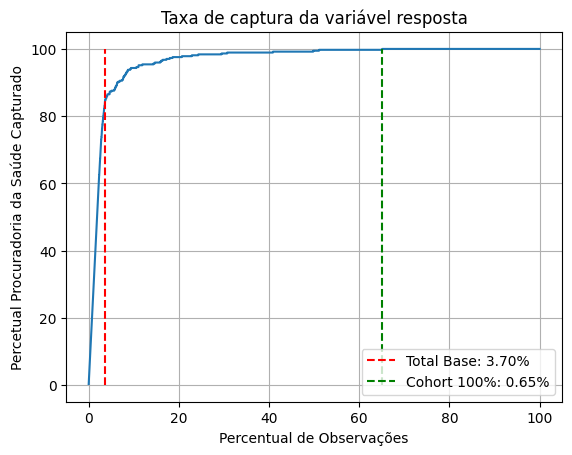

In [ ]:
N = 6

plt.plot(100*reports[N]['PCT_OBS'], 100*reports[N]['PCT_ACUM_CLASS'])
plt.grid(True)
plt.title('Taxa de captura da variável resposta')
plt.xlabel('Percentual de Observações')
plt.ylabel(f'Percetual {reports[N].columns[0]} Capturado')
plt.vlines(x=100*reports[N]['MEAN_CLASS'].min(), ymin=0, ymax=100, colors='r', linestyles='dashed', label=f'Total Base: {100*reports[N]['MEAN_CLASS'].min():.2f}%')

cohoort_100 = reports[N][reports[N]['PCT_ACUM_CLASS'] == 1].iloc[0]['PCT_OBS']
plt.vlines(x=100*cohoort_100, ymin=0, ymax=100, colors='g', linestyles='dashed', label=f'Cohort 100%: {cohoort_100:.2f}%')

plt.legend()
plt.show()

In [ ]:
reports[N][reports[N]['PCT_ACUM_CLASS'] == 1].iloc[0]['PCT_OBS']

5630    0.872564
Name: PCT_OBS, dtype: float64

In [ ]:
cohoort_100

,Apoio Fiscal,PRED,ACUM_CLASS,PCT_ACUM_CLASS,QTDE_OBS,PCT_OBS,MEAN_CLASS,LIFT_CLASS
5630,1,0.000316,2879,1.0,8730,0.872564,0.329782,1.146048


In [ ]:
reports[N]

,Apoio Fiscal,PRED,ACUM_CLASS,PCT_ACUM_CLASS,QTDE_OBS,PCT_OBS,MEAN_CLASS,LIFT_CLASS
8974,1,0.995206,1,0.000347,1,0.0001,1.000000,3.475165
5166,1,0.995206,2,0.000695,2,0.0002,1.000000,3.475165
273,1,0.995206,3,0.001042,3,0.0003,1.000000,3.475165
8976,1,0.995049,4,0.001389,4,0.0004,1.000000,3.475165
5180,1,0.994435,5,0.001737,5,0.0005,1.000000,3.475165
...,...,...,...,...,...,...,...,...
4224,0,0.000016,2879,1.000000,10001,0.9996,0.287871,1.000400
6760,0,0.000016,2879,1.000000,10002,0.9997,0.287842,1.000300
1980,0,0.000016,2879,1.000000,10003,0.9998,0.287814,1.000200
2821,0,0.000013,2879,1.000000,10004,0.9999,0.287785,1.000100
